In [93]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
from pprint import pprint
from geopy.distance import geodesic
from tqdm import tqdm
plt.rcParams["figure.dpi"] = 100

sys.path.insert(1, '/Users/jarvis/PATH_vehicle_localization/src')
from util import *

### Data Loading
- 100Hz
- Ground truth RTK-GPS coordinates with augmented left and right lane markings

In [55]:
ll_marks = pd.read_csv('../data/acm_track/augmented_lane_line/ll_lane.csv.gzip', compression='gzip', index_col=0)
rl_marks = pd.read_csv('../data/acm_track/augmented_lane_line/rl_lane.csv.gzip', compression='gzip', index_col=0)

ll_marks = ll_marks[['y', 'x', 'Vx', 'left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon', 'Distance horizontal (m)']]
rl_marks = rl_marks[['y', 'x', 'Vx', 'left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon', 'Distance horizontal (m)']]

In [56]:
ll_marks.head()

,y,x,Vx,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,Distance horizontal (m)
0,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.0
1,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.0
2,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.0
3,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.0
4,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.0


In [52]:
# points per meter ~= 20
ll_marks.shape[0] / ll_marks['Distance horizontal (m)'].values[-1], rl_marks.shape[0] / rl_marks['Distance horizontal (m)'].values[-1]

(19.111790358365297, 21.909061145434567)

### Lon. Speed Integration

### GPS Sampling

- 100Hz to 10Hz

In [47]:
ll_sampled_noise = sample_gps(ll_marks, sampling_rate=10)
rl_sampled_noise = sample_gps(rl_marks, sampling_rate=10)

print(ll_sampled_noise.shape)

(7082, 7)


In [49]:
ll_sampled_noise[(ll_sampled_noise['Distance horizontal (m)'] >= 100) & (ll_sampled_noise['Distance horizontal (m)'] <= 110)].shape[0]

20

### GPS Noise Augmentation

- https://wiki.gis.com/wiki/index.php/Decimal_degrees
- 5 decimal places corresponds to an accuracy of 11.1 meters (+/- 5.55m) at the equator

#### scratch work

In [6]:
np.random.seed(0)
seeds = np.random.randint(10, size=3)

for seed in seeds:
    np.random.seed(seed)
    print(np.random.randint(5))

3
4
2


(array([ 1.,  5.,  7., 13., 17., 18., 16., 11.,  7.,  5.]),
 array([-1.27649491e-05, -1.03535769e-05, -7.94220464e-06, -5.53083242e-06,
        -3.11946020e-06, -7.08087980e-07,  1.70328424e-06,  4.11465646e-06,
         6.52602868e-06,  8.93740090e-06,  1.13487731e-05]),
 <BarContainer object of 10 artists>)

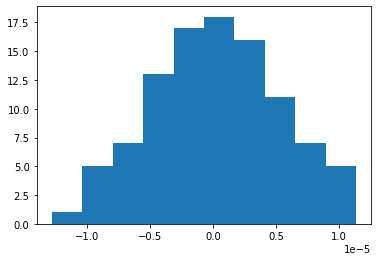

In [7]:
np.random.seed(0)
plt.hist(0.00001 * 0.5 * np.random.randn(100))

In [257]:
colns = ['left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon']
ll_sampled_noise = gps_noise_augmentation(ll_sampled_noise, 0.000005, colns, seed=1)
rl_sampled_noise = gps_noise_augmentation(rl_sampled_noise, 0.000005, colns, seed=2)

Random seeds = [5 8 9 5]
Random seeds = [8 8 6 2]


In [12]:
rl_sampled_noise.head()

,y,x,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,left_mark_lat_noise,left_mark_lon_noise,right_mark_lat_noise,right_mark_lon_noise
0,42.238584,-83.557726,-83.557709,42.238566,-83.557742,42.238601,-83.557709,42.238566,-83.557743,42.238599
10,42.238584,-83.557726,-83.557709,42.238566,-83.557742,42.238601,-83.557704,42.238571,-83.557738,42.238601
20,42.238584,-83.557726,-83.557709,42.238566,-83.557742,42.238601,-83.557719,42.238556,-83.557741,42.238591
30,42.238584,-83.557726,-83.557709,42.238566,-83.557742,42.238601,-83.557716,42.238559,-83.557746,42.238610
40,42.238584,-83.557726,-83.557709,42.238566,-83.557742,42.238601,-83.557721,42.238554,-83.557754,42.238592


In [90]:
def traj_gps_error(traj_df, colns1, colns2) -> np.ndarray:
    """
    calculates the GPS coordinate error between (colns1.lat, colns1.lon) and (colns2.lat, colns2.lon)
    distance metric: geodesic
    """
    error = []
    lat1 = traj_df[colns1[0]].values
    lon1 = traj_df[colns1[1]].values

    if type(colns2[0]) == str:    
        lat2 = traj_df[colns2[0]].values
        lon2 = traj_df[colns2[1]].values
    else:
        lat2 = colns2[0] * np.ones_like(lat1)
        lon2 = colns2[1] * np.ones_like(lon1)

    def get_distance(lat1, lon1, lat2, lon2):
        point1 = (lat1, lon1)
        point2 = (lat2, lon2)
        return geodesic(point1, point2).meters
    
    error = np.vectorize(get_distance)(
        lat1, lon1, lat2, lon2
    )
    return error

In [258]:
# left lane, left lanemark

ll_mark_error_l = traj_gps_error(
    ll_sampled_noise, 
    colns1=['left_mark_lat', 'left_mark_lon'], colns2=['left_mark_lat_noise', 'left_mark_lon_noise']
)

pprint(ll_mark_error_l.mean())
pprint(ll_mark_error_l.std())

0.2283798921294963
0.16373160031940776


In [259]:
# left lane, right lanemark

ll_mark_error_r = traj_gps_error(
    ll_sampled_noise, 
    colns1=['right_mark_lat', 'right_mark_lon'], colns2=['right_mark_lat_noise', 'right_mark_lon_noise']
)

pprint(ll_mark_error_r.mean())
pprint(ll_mark_error_r.std())

0.2267288010150975
0.1683601904470513


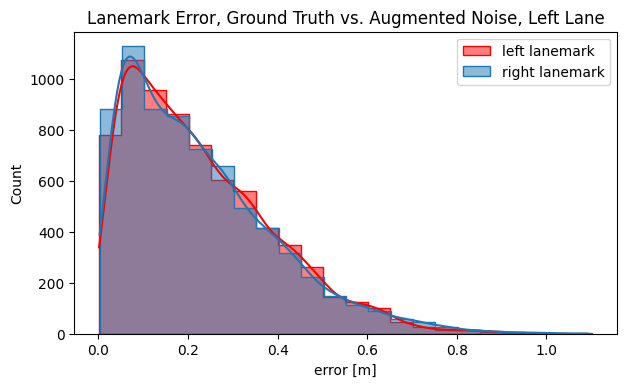

In [38]:
plt.figure(figsize=(7, 4), dpi=100)
sns.histplot(ll_mark_error_l, binwidth=0.05, label='left lanemark', kde=True, color='red', element = "step")
sns.histplot(ll_mark_error_r, binwidth=0.05, label='right lanemark', kde=True, element = "step")
plt.legend()
plt.xlabel('error [m]')
plt.title('Lanemark Error, Ground Truth vs. Augmented Noise, Left Lane')
plt.show()

## Map-Matching

### Building Local Map
- Using unsampled ground truth reference data 
- Separate local search map for left and right lanemark


Method 1: Sliding windows\
Method 2: Buffer

In [160]:
m = 2 # [m]

#### Sample Test

In [169]:
rl_sampled_noise.sample()

,y,x,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,Distance horizontal (m),left_mark_lat_noise,left_mark_lon_noise,right_mark_lat_noise,right_mark_lon_noise
16440,42.241908,-83.551636,-83.551632,42.241768,-83.551641,42.242049,668.577,-83.551632,42.241769,-83.551641,42.242048


In [276]:
def build_m(lane_ref, point, m) -> pd.DataFrame:
    
    bound1 = geodesic(meters=m/2).destination(
        point, bearing=45
    )
    bound2 = geodesic(meters=m/2).destination(
        point, bearing=225
    )

    local_map = lane_ref[
        (lane_ref['left_mark_lat'] <= bound1.latitude) &\
        (lane_ref['left_mark_lat'] >= bound2.latitude) &\
        (lane_ref['left_mark_lon'] <= bound1.longitude) &\
        (lane_ref['left_mark_lon'] >= bound2.longitude)
    ]

    # pprint(f'{local_map.shape[0]} references points are found in the local search map')

    return local_map

In [277]:
def get_cloest_ref(local_map, point: geopy.Point) -> np.ndarray:
    
    error = traj_gps_error(local_map, ['left_mark_lat', 'left_mark_lon'], [point.latitude, point.longitude])
    idx = np.argmin(error)
    cloest_ref = np.array([
        local_map['left_mark_lat'].values[idx], local_map['left_mark_lon'].values[idx]
    ])
    
    return cloest_ref

In [275]:
def map_matching(lane_ref, est, m):

    # left lanemark
    ref_opt_lat = []
    ref_opt_lon = []
    local_map_size = []

    for idx in tqdm(range(est.shape[0])):
        est_point = geopy.Point(est['left_mark_lat_noise'].values[idx], est['left_mark_lon_noise'].values[idx])
        local_map = build_m(lane_ref, est_point, m)
        local_map_size.append(local_map.shape[0])
        ref_opt = get_cloest_ref(local_map, est_point)
        ref_opt_lat.append(ref_opt[0])
        ref_opt_lon.append(ref_opt[1])

    est['ref_opt_lat'] = ref_opt_lat
    est['ref_opt_lon'] = ref_opt_lon

    return est, local_map_size

In [278]:
ll_mapmatch, local_map_sizes = map_matching(ll_marks, ll_sampled_noise, m=2)

100%|██████████| 7082/7082 [00:55<00:00, 126.57it/s]


In [280]:
np.average(local_map_sizes)

54.39508613386049

In [184]:
ll_mapmatch

,y,x,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,Distance horizontal (m),left_mark_lat_noise,left_mark_lon_noise,right_mark_lat_noise,right_mark_lon_noise,ref_opt_lat,ref_opt_lon
0,42.238643,-83.557448,-83.557432,42.238624,-83.557465,42.238662,0.000,-83.557431,42.238624,-83.557465,42.238663,-83.557431,42.238624
10,42.238643,-83.557448,-83.557432,42.238624,-83.557465,42.238662,0.001,-83.557433,42.238626,-83.557465,42.238661,-83.557433,42.238627
20,42.238643,-83.557448,-83.557432,42.238624,-83.557464,42.238662,0.002,-83.557426,42.238619,-83.557467,42.238668,-83.557426,42.238624
30,42.238643,-83.557448,-83.557432,42.238624,-83.557464,42.238662,0.003,-83.557433,42.238620,-83.557465,42.238662,-83.557432,42.238624
40,42.238643,-83.557448,-83.557432,42.238624,-83.557464,42.238662,0.004,-83.557432,42.238618,-83.557465,42.238663,-83.557432,42.238624
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70770,42.238652,-83.557370,-83.557354,42.238634,-83.557387,42.238670,3704.185,-83.557351,42.238627,-83.557389,42.238673,-83.557352,42.238633
70780,42.238652,-83.557367,-83.557351,42.238634,-83.557383,42.238670,3704.467,-83.557348,42.238636,-83.557381,42.238673,-83.557348,42.238634
70790,42.238652,-83.557364,-83.557347,42.238634,-83.557380,42.238670,3704.740,-83.557346,42.238634,-83.557380,42.238672,-83.557346,42.238633
70800,42.238653,-83.557360,-83.557344,42.238635,-83.557377,42.238671,3705.004,-83.557346,42.238633,-83.557380,42.238669,-83.557345,42.238633


In [120]:
ll_mapmatch_error_l = traj_gps_error(
    ll_mapmatch, 
    colns1=['left_mark_lat', 'left_mark_lon'], colns2=['ref_opt_lat', 'ref_opt_lon']
)
print(ll_mapmatch_error_l.mean(), ll_mapmatch_error_l.std())

0.2086307813619389 0.16286320633636495


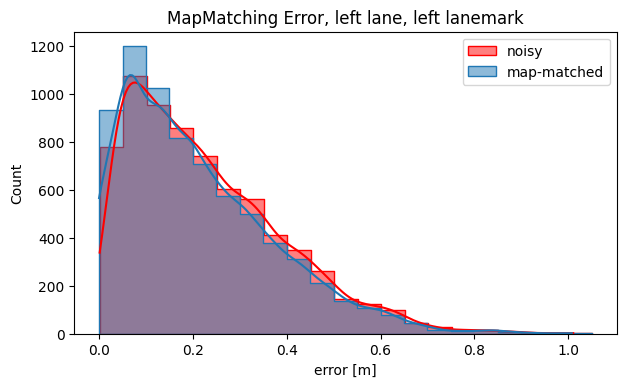

In [150]:
plt.figure(figsize=(7, 4), dpi=100)
sns.histplot(ll_mark_error_l, binwidth=0.05, label='noisy', kde=True, color='red', element = "step")
sns.histplot(ll_mapmatch_error_l, binwidth=0.05, label='map-matched', kde=True, element = "step")
plt.legend()
plt.xlabel('error [m]')
plt.title('MapMatching Error, left lane, left lanemark')
plt.show()

In [227]:
ll_mapmatch.sample()

,y,x,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,Distance horizontal (m),left_mark_lat_noise,left_mark_lon_noise,right_mark_lat_noise,right_mark_lon_noise,ref_opt_lat,ref_opt_lon
60450,42.239178,-83.563451,-83.563439,42.239283,-83.563462,42.239074,3176.102,-83.563436,42.239279,-83.56346,42.239078,-83.563435,42.239279


In [266]:
m = 2
sample = ll_mapmatch.sample()
point = geopy.Point(sample['left_mark_lat_noise'].iloc[0], sample['left_mark_lon_noise'].iloc[0])
point_gt = geopy.Point(sample['left_mark_lat'].iloc[0], sample['left_mark_lon'].iloc[0])
point_mm = geopy.Point(sample['ref_opt_lat'].iloc[0], sample['ref_opt_lon'].iloc[0])

bound1 = geodesic(meters=m/2).destination(
        point, bearing=45
    )

bound2 = geodesic(meters=m/2).destination(
        point, bearing=225
    )

local_map = ll_marks[(ll_marks['left_mark_lat'] <= bound1.latitude) &\
        (ll_marks['left_mark_lat'] >= bound2.latitude) &\
        (ll_marks['left_mark_lon'] <= bound1.longitude) &\
        (ll_marks['left_mark_lon'] >= bound2.longitude)]

local_map.shape

(61, 8)

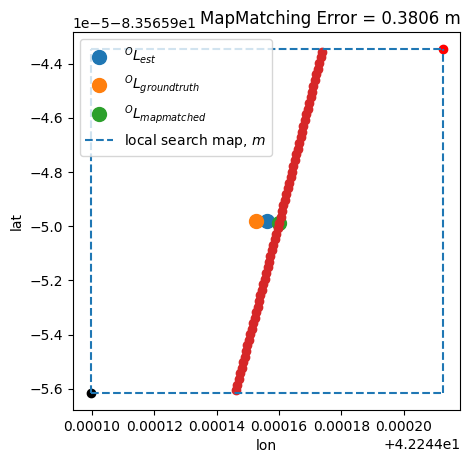

In [267]:
error = geodesic(point_mm, point_gt).meters
plt.figure(figsize=(5, 5))
plt.scatter(point.longitude, point.latitude, s=100, label=r'$^OL_{est}$')
plt.scatter(point_gt.longitude, point.latitude, s=100, label=r'$^OL_{ground truth}$')
plt.scatter(point_mm.longitude, point_mm.latitude, s=100, label=r'$^OL_{mapmatched}$')

plt.hlines(y=bound1.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--', label=r'local search map, $m$')
plt.vlines(x=bound2.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')
plt.hlines(y=bound2.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--')
plt.vlines(x=bound1.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')

plt.scatter(bound1.longitude, bound1.latitude, color='red')
plt.scatter(bound2.longitude, bound2.latitude, color='black')

plt.scatter(local_map['left_mark_lon'], local_map['left_mark_lat'])
plt.xlabel('lon')
plt.ylabel('lat')

plt.title(f'MapMatching Error = {round(error, 4)} m', loc='right')
plt.legend()
plt.show()
